<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.07 Variational AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - Variational AutoEncoder를 이해하고 구현한다.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts/')
from lib import *

## VAE 기본 구현
---

![](https://user-images.githubusercontent.com/24144491/50323466-18d03700-051d-11e9-82ed-afb1b6e2666a.png)

### **| Encoder, Decoder 구현**

In [ ]:
class Sampling(layers.Layer): # 상속

  def call(self, inputs):
    z_mu, z_sigma = inputs
    z_epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mu))
    z = ( tf.exp(z_epsilon*0.5) * z_sigma ) + z_mu
    return z

class BuildModel():
  def __init__(self, x_shape=(28,28,1), z_dims=100):
    self.x_shape = x_shape
    self.z_dims = z_dims

  def build_encoder(self):
    x = layers.Input(shape = self.x_shape )
    z = layers.Conv2D(32, 3, strides=2, padding='same', activation='leaky_relu')(x)
    z = layers.Conv2D(32, 3, strides=2, padding='same', activation='leaky_relu')(z)
    self.z_conv_shape = z.shape[1:] # (7, 7, 32)
 
    z = layers.Flatten()(z)
    z_mu = layers.Dense(z_dims, activation='relu')(z)
    z_sigma = layers.Dense(z_dims, activation='relu')(z)

    z = Sampling()([z_mu, z_sigma])
    encoder = models.Model(x, [z_mu, z_sigma, z], name='Encoder')
    return encoder

  def build_decoder(self):
    z = layers.Input(shape = self.z_dims)
    y = layers.Dense(256, activation='relu')(z)
    dim = self.z_conv_shape[0]*self.z_conv_shape[1]*self.z_conv_shape[2]
    y = layers.Dense(dim, activation = 'relu')(y)
    y = layers.Reshape(self.z_conv_shape)(y)
    y = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='leaky_relu')(y)
    y = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(y)

    decoder = models.Model(z, y, name='Decoder')
    return decoder

In [ ]:
x_shape = (28,28,1)
z_dims = 10
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()
encoder.summary()
decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 32)   320         ['input_14[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 7, 7, 32)     9248        ['conv2d_18[0][0]']              
                                                                                                  
 flatten_9 (Flatten)            (None, 1568)         0           ['conv2d_19[0][0]']              
                                                                                            

### **| 손실함수 정의**

![](https://user-images.githubusercontent.com/24144491/50323472-1a016400-051d-11e9-86b7-d8bf6a1a880f.png)

In [ ]:
'''loss.py'''
def get_rec_loss(imgs, recs):
  rec_loss = tf.keras.losses.binary_crossentropy(imgs, recs)
  rec_loss = tf.reduce_mean(rec_loss)
  return rec_loss

def get_kl_loss(z_mu, z_sigma):
  kl_loss = tf.square(z_mu) + ( tf.exp(z_sigma) - z_sigma - 1)
  kl_loss = 0.5*tf.reduce_mean(kl_loss)
  return kl_loss

### **| VAE 구현**

In [ ]:
class VAE():
  def __init__(self, encoder, decoder, x_shape):
    self.encoder = encoder
    self.decoder = decoder
    self.x_shape = x_shape

  def compile(self, optimizer = tf.keras.optimizers.Adam() ):
    img = layers.Input(shape = x_shape)
    z_mu, z_sigma, z  = self.encoder(img)
    rec = self.decoder(z)

    self.vae = models.Model(img, rec, name='VAE')
    self.optimizer = optimizer

  @tf.function
  def train_step(self, imgs):
    # imgs.shape = (16, 28, 28, 1)
    with tf.GradientTape() as tape:
      
      # propagation
      z_mu, z_sigma, z = self.encoder(imgs)
      recs = self.decoder(z)

      # loss 계산 - (rec loss / kl loss)
      rec_loss = get_rec_loss(imgs, recs) # 원본 이미지와 재구성한 이미지가 최대한 비슷해지면 좋겠다
      kl_loss = get_kl_loss(z_mu, z_sigma) # z가 다양하면서, 정보량 유사
      loss = rec_loss + kl_loss

    # gradient 계산
    weights = self.vae.trainable_variables
    gradients = tape.gradient(loss, weights)

    # weight 업데이트
    self.optimizer.apply_gradients(zip(gradients,weights))

    return loss, rec_loss, kl_loss

  def fit(self, x_data, epochs = 1, batch_size=16):

    train_ds = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)
    self.batch_size=batch_size
    history = {'loss':[0 for i in range(epochs)], 
               'rec_loss':[0 for i in range(epochs)], 
               'kl_loss':[0 for i in range(epochs)] }

    for epoch in range(1, epochs+1):
      self.epoch=epoch     
      for imgs in train_ds:
        loss, rec_loss, kl_loss = self.train_step(imgs)
        loss, rec_loss, kl_loss = loss.numpy(), rec_loss.numpy(), kl_loss.numpy()
        history['loss'][epoch-1]+=loss
        history['rec_loss'][epoch-1]+=rec_loss
        history['kl_loss'][epoch-1]+=kl_loss
        
      print( f"* [ {epoch} / {epochs}]  loss: {history['loss'][epoch-1]} rec_loss: {history['rec_loss'][epoch-1]} kl_loss: {history['kl_loss'][epoch-1]}" )
      self.plot_sample_imgs(imgs)

  def plot_sample_imgs(self, imgs, n=10):
    plt.figure(figsize=(n,2))
    rec_imgs = self.vae.predict(imgs[:n])
    for i, (img, rec_img) in enumerate(zip(imgs, rec_imgs)):
        plt.subplot(2,n,i+1)
        plt.imshow(np.squeeze(img), cmap='gray_r')
        plt.axis('off')
        plt.subplot(2,n,n+i+1)
        plt.imshow(np.squeeze(rec_img), cmap='gray_r')
        plt.axis('off')
    plt.show()

### **| 학습**

In [ ]:
def get_mnist():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_train = x_train.astype(np.float32) / 255
  x_train = x_train.reshape(-1, 28, 28, 1)
  x_test = x_test.astype(np.float32) / 255
  x_test = x_test.reshape(-1, 28, 28, 1)

  return x_train, x_test

In [ ]:
x_train, x_test = get_mnist()
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
x_shape = (28,28,1)
z_dims = 100
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()

vae = VAE(encoder, decoder, x_shape)
vae.compile()
vae.vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 100),             323368    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         438369    
                                                                 
Total params: 761,737
Trainable params: 761,737
Non-trainable params: 0
_________________________________________________________________


* [ 1 / 5]  loss: 464.18529982864857 rec_loss: 454.49539993703365 kl_loss: 9.687600032841146


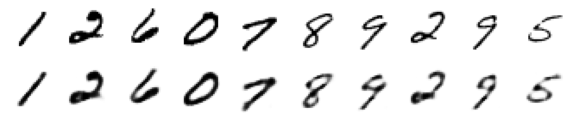

* [ 2 / 5]  loss: 310.0990002155304 rec_loss: 305.6994000002742 kl_loss: 4.404100038460456


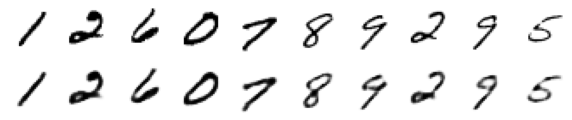

* [ 3 / 5]  loss: 288.29500030353665 rec_loss: 285.22990035265684 kl_loss: 3.064099941868335


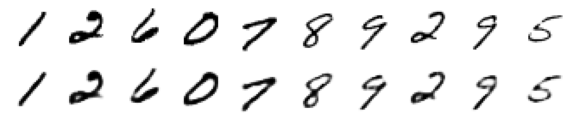

* [ 4 / 5]  loss: 278.6422004327178 rec_loss: 276.0985004045069 kl_loss: 2.544299971021246


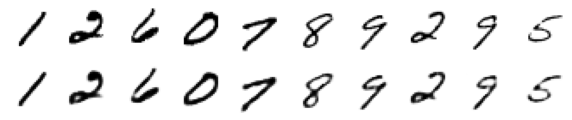

* [ 5 / 5]  loss: 273.1128003895283 rec_loss: 270.82940058782697 kl_loss: 2.2868000679591205


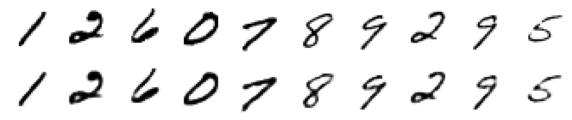

In [ ]:
vae.fit(x_train, 5)

### **| 결과 확인**

## 새소리 클러스터링
---

In [ ]:
! unzip /content/drive-download-20220902T001337Z-001.zip -d wav_data

In [5]:
! git clone https://github.com/yebiny/Songbird-clusturing.git

Cloning into 'Songbird-clusturing'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 332 (delta 32), reused 65 (delta 18), pack-reused 227
Receiving objects: 100% (332/332), 49.60 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [7]:
sys.path.append('/content/Songbird-clusturing/data_process')
from syllable_generator import *
from draw_tools import *

In [8]:
gen = SyllableGenerator('/content/wav_data')

In [ ]:
gen.wav_list

/content/wav_data/w58y67_20200428_100953_641.wav


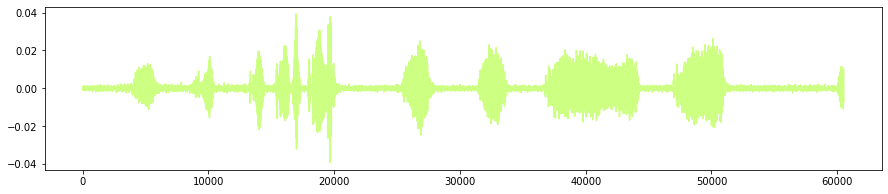

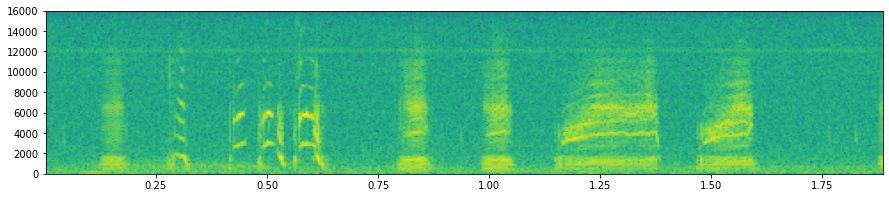

In [19]:
idx = 0
wav = gen.wav_list[idx]
print(wav)

draw_wav(wav)
draw_spectrogram(wav)

In [14]:
syllables = gen.get_syllable_list(gen.wav_list)

* Finish Idx 0 wav file :  w58y67_20200428_100953_641
* Finish Idx 10 wav file :  w58y67_20200428_112731_559
* Finish Idx 20 wav file :  w58y67_20200428_115428_195
* Finish Idx 30 wav file :  w58y67_20200428_115802_306
* Finish Idx 40 wav file :  w58y67_20200428_115916_607
* Finish Idx 50 wav file :  w58y67_20200428_120203_663


In [20]:
print(syllables.shape)
print(' idx  startPoint  length')
print(syllables[:3])

wav_idx = syllables[:, 0]
start_point = syllables[:,1]
length = syllables[:,2]

(765, 3)
 idx  startPoint  length
[[    0  3891  2001]
 [    0  8697  1882]
 [    0 13002  1608]]


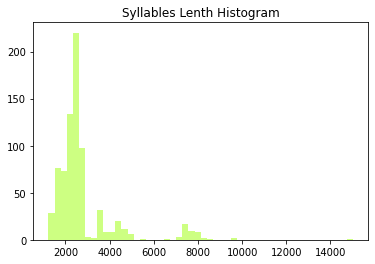

In [22]:
hist_syllable_lenth(length)

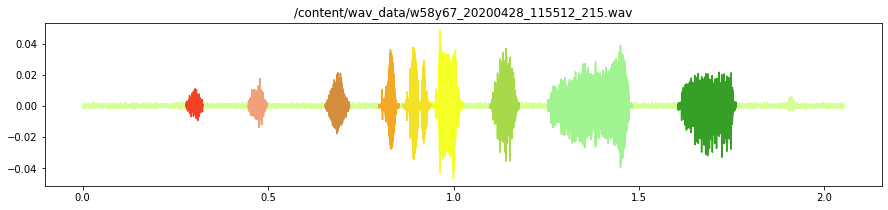

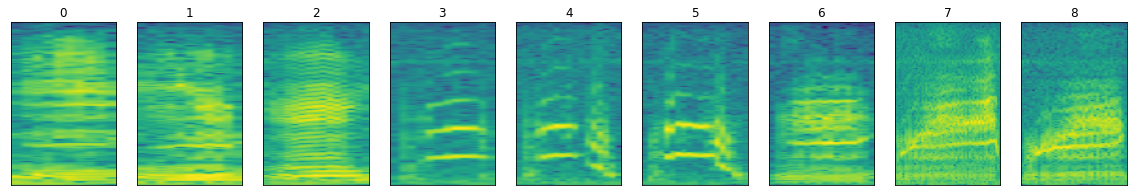

In [27]:
idx = 26
draw_split_wav(gen.wav_list, syllables, idx)
draw_split_spectrogram(gen.wav_list, syllables, idx)

In [29]:
from data_process import *

dp = DataProcess(gen.wav_list, syllables)

ys, imgs = dp.get_dataset()
ys.shape, imgs.shape

* Start process...  total syllables: 765
0
100
200
300
400
500
600
700


((765,), (765, 128, 64))

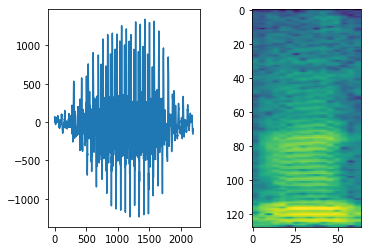

In [30]:
plt.subplot(121); plt.plot(ys[idx])
plt.subplot(122); plt.imshow(imgs[idx])

(765, 128, 64, 1)

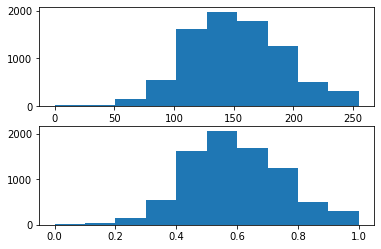

In [34]:
x_data = imgs / 255.
x_data = np.expand_dims(x_data, 3)
plt.subplot(211);plt.hist(imgs[0].flatten())
plt.subplot(212);plt.hist(x_data[0].flatten())
x_data.shape

In [37]:
np.save('wav_data/pre/x_train', x_data)
np.save('wav_data/pre/x_test', x_data)

In [35]:
sys.path.append('/content/Songbird-clusturing/2-Train')
from trainVAE_ver1 import *

In [40]:
z_dims = 2
data_path = 'wav_data/' 
save_path = 'result'
vae = TrainVAE(z_dims, data_path, save_path)
vae.vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 64, 1)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               357284    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 64, 1)        357761    
                                                                 
Total params: 715,045
Trainable params: 715,045
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae.train(1000, 4)

* 0 * loss: 5501.173828,  best_loss: 5501.173828, l_rate: 0.001000, lr_count: 0
* 1 * loss: 5354.821289,  best_loss: 5354.821289, l_rate: 0.001000, lr_count: 0
* 2 * loss: 5292.292480,  best_loss: 5292.292480, l_rate: 0.001000, lr_count: 0
* 3 * loss: 5276.803223,  best_loss: 5276.803223, l_rate: 0.001000, lr_count: 0
* 4 * loss: 5268.788086,  best_loss: 5268.788086, l_rate: 0.001000, lr_count: 0
* 5 * loss: 5265.714355,  best_loss: 5265.714355, l_rate: 0.001000, lr_count: 0
* 6 * loss: 5261.982910,  best_loss: 5261.982910, l_rate: 0.001000, lr_count: 0
* 7 * loss: 5259.573242,  best_loss: 5259.573242, l_rate: 0.001000, lr_count: 0
* 8 * loss: 5252.896973,  best_loss: 5252.896973, l_rate: 0.001000, lr_count: 0
* 9 * loss: 5252.272461,  best_loss: 5252.272461, l_rate: 0.001000, lr_count: 0
* 10 * loss: 5247.294922,  best_loss: 5247.294922, l_rate: 0.001000, lr_count: 0
* 11 * loss: 5243.965332,  best_loss: 5243.965332, l_rate: 0.001000, lr_count: 0
* 12 * loss: 5242.047363,  best_loss: 